# Exact Diagonalization of 2D J-Q Hamiltonian
    Himadri Halder, S. Pujari Group
    2024, IIT Bombay

In [1]:
# Load the source files
include("../source/J-Q_ED.jl")

VBS_0p_structure (generic function with 1 method)

### Storing Mz - kx,ky - z Basis

In [2]:
# Set Nx and Ny
Nx,Ny = 4,2

# Generate lattice points in order to perform translations
x_lattice = lattice_x(Nx,Ny)
y_lattice = lattice_y(Nx,Ny)

mz = 0.0

#******kx_ky list for small system (both odd and even)******
# kx_ky = [(i,j) for i in 0:Nx-1,j in 0:Ny-1]
#******kx_ky list for large system (both odd and even)******
kx_ky = [(i,j) for i in 0:Int(ceil(Nx/2)),j in 0:Int(ceil(Ny/2))]
# ******kx_ky list when Nx, Ny both even and multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2)),(0,Int(Ny/4)),(Int(Nx/4),Int(Ny/2))]
#******kx_ky list when Nx, Ny both even but not multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2))]

z_list = [1,-1]

@time begin
    # Folder path to store data
    folder_name = "D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Basis\\Mz_kx_ky_z_basis\\Mz=$(mz)"
    if !isdir(folder_name)
        mkpath(folder_name)
    end

    for (kx,ky) in kx_ky
        for z in z_list
            H_size,basis_list,D_list,Na_list = gen_basis_mz_k_z(Nx,Ny,mz,kx,ky,z,x_lattice,y_lattice)

            # File path to save data
            file_name = "Basis_mx=$(kx)_my=$(ky)_z=$(z).jld2"
            full_path = joinpath(folder_name,file_name)
            if length(basis_list) != 0
                # Save using JLD2
                @save full_path H_size basis_list D_list Na_list
            end
        end
    end
end

  0.878526 seconds (232.77 k allocations: 15.322 MiB, 35.61% compilation time: 60% of which was recompilation)


### Storing Sparse S^2 Matrix

In [38]:
Nx,Ny = 4,4

# Generate lattice points in order to perform translations
x_lattice = lattice_x(Nx,Ny)
y_lattice = lattice_y(Nx,Ny)

mz = 0.0

#******kx_ky list for small system (both odd and even)******
kx_ky = [(i,j) for i in 0:Nx-1,j in 0:Ny-1]
#******kx_ky list for large system (both odd and even)******
# kx_ky = [(i,j) for i in 0:Int(ceil(Nx/2)),j in 0:Int(ceil(Ny/2))]
#******kx_ky list when Nx, Ny both even and multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2)),(0,Int(Ny/4)),(Int(Nx/4),Int(Ny/2))]
#******kx_ky list when Nx, Ny both even but not multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2))]

z_list = [1,-1]

@time begin
    folder_name = ("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Sparse_S2\\Mz=$(mz)")
    if !isdir(folder_name)
        mkpath(folder_name)
    end
    for (kx,ky) in kx_ky
        for z in z_list

            # Load basis information from .jld2 file
            basis_file = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Basis\\Mz_kx_ky_z_basis",
                                  "Mz=$(mz)\\Basis_mx=$(kx)_my=$(ky)_z=$(z).jld2")
            if isfile(basis_file)
                basis_info = JLD2.load(basis_file)
                basis_list = basis_info["basis_list"]
                Na_list = basis_info["Na_list"]

                # Preallocate memory
                basis_copy = x_tstate = xy_tstate = similar(state_bin(basis_list[1],Nx*Ny)) 
                # Call the function to compute sparse matrix
                Total_S,Elems_count = Sparse_S2(Nx,Ny,kx,ky,z,basis_list,Na_list,x_lattice,y_lattice,
                                                                      basis_copy,x_tstate,xy_tstate)

                # Save the sparse matrix using JLD2
                output_file = joinpath(folder_name,"Sparse_S2_mx=$(kx)_my=$(ky)_z=$(z).jld2")
                @save output_file Total_S
            else
                println("File doesn't exist; skipping process for (Mz,mx,my,z) = ($mz,$kx,$ky,$z)")
            end
        end
    end
end

  4.518662 seconds (40.57 M allocations: 1.951 GiB, 3.04% gc time, 13.07% compilation time: 94% of which was recompilation)


### Storing Sparse/Dense Hamiltonian

###### Be careful while using Lanczos: use lanczos only with sparse matrices to avoid cost at matrix-vector multiplication. But don't use lanczos for lattice smaller than 4X4 as smaller matrices will give erroneous results upon using lanczos due to numerical instability

#### 1) Varying J and Varying Q ( J+Q = 1)

In [4]:
Nx,Ny = 4,2
use_sparse = false   # Set 'true' to store sparse matrix and 'false' to store dense matrix

if use_sparse == true
    if Nx*Ny >= 16
        nothing
    else
        error("ERROR: Please use Sparse and Lanczos only for Nx*Ny >= 16 otherwise use Dense matrix and eigen() package")
    end
else
    nothing
end

x_lattice = lattice_x(Nx,Ny)
y_lattice = lattice_y(Nx,Ny)
Jbonds,Qbonds = bond_list(Nx,Ny)

# Define R values
A_list = LinRange(0,0.9,10)
B_list = LinRange(0.9,1,5)
R_list = vcat(A_list,B_list)

mz = 0.0

#******kx_ky list for small system (both odd and even)******
kx_ky = [(i,j) for i in 0:Nx-1,j in 0:Ny-1]
#******kx_ky list for large system (both odd and even)******
# kx_ky = [(i,j) for i in 0:Int(ceil(Nx/2)),j in 0:Int(ceil(Ny/2))]
#******kx_ky list when Nx, Ny both even and multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2)),(0,Int(Ny/4)),(Int(Nx/4),Int(Ny/2))]
#******kx_ky list when Nx, Ny both even but not multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2))]

z_list = [1,-1]

@time begin
    for (kx,ky) in kx_ky
        for z in z_list

            basis_file = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Basis\\Mz_kx_ky_z_basis",
                    "Mz=$(mz)\\Basis_mx=$(kx)_my=$(ky)_z=$(z).jld2")
            if isfile(basis_file)
                basis_info = JLD2.load(basis_file)
                basis_list = basis_info["basis_list"]
                Na_list = basis_info["Na_list"]

                #Pre-allocate memory for in-place modification later
                basis_copy = x_tstate = xy_tstate = flipped_basis = similar(state_bin(basis_list[1],Nx*Ny))

                folder_name_ham = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                        "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z)")
                if !isdir(folder_name_ham)
                    mkpath(folder_name_ham)
                end

                for R in R_list
                    J = 1-R
                    Q = R

                    # Generate Hamiltonians
                    Ham_J,H_size,basis_list,Na_list = 
                    JQ_Ham_J(J,Nx,Ny,kx,ky,z,basis_list,Na_list,x_lattice,y_lattice,Jbonds,use_sparse,basis_copy,
                             x_tstate,xy_tstate)
                    Ham_Q,H_size,basis_list,Na_list = 
                    JQ_Ham_Q(Q,Nx,Ny,kx,ky,z,basis_list,Na_list,x_lattice,y_lattice,Qbonds,use_sparse,basis_copy,
                             flipped_basis,x_tstate,xy_tstate)
                    # Save Hamiltonians in appropriate format
                    if use_sparse == true
                        J_file_path = joinpath(folder_name_ham,"Sparse_ham_J=$(round(J,digits=8)).jld2")
                        Q_file_path = joinpath(folder_name_ham,"Sparse_ham_Q=$(round(Q,digits=8)).jld2")
                        @save J_file_path Ham_J
                        @save Q_file_path Ham_Q
                    else
                        J_file_path = joinpath(folder_name_ham,"Dense_ham_J=$(round(J,digits=8)).jld2")
                        Q_file_path = joinpath(folder_name_ham,"Dense_ham_Q=$(round(Q,digits=8)).jld2")
                        @save J_file_path Ham_J
                        @save Q_file_path Ham_Q
                    end
                end
            else
                println("File doesn't exist; skipping process for (Mz,mx,my,z) = ($mz,$kx,$ky,$z)")
            end                    
        end
    end
end          

  3.039029 seconds (1.16 M allocations: 59.855 MiB, 0.28% gc time, 10.11% compilation time: 76% of which was recompilation)


In [6]:
Nx,Ny = 4,2
mz = 0.0
kx,ky = 2,0
x_lattice = lattice_x(Nx,Ny)
y_lattice = lattice_y(Nx,Ny)
z = -1
H_size,basis_list,D_list,Na_list = gen_basis_mz_k_z(Nx,Ny,mz,kx,ky,z,x_lattice,y_lattice)

(3, [23, 53, 85], [16, 16, 2], [16.0, 16.0, 128.0])

### Diagonalization and Storing Energies

###### Be careful while using Lanczos: use lanczos only with sparse matrices to avoid cost at matrix-vector multiplication. But don't use lanczos for lattice smaller than 4X4 as smaller matrices will give erroneous results upon using lanczos due to numerical instability

In [2]:
Nx,Ny = 4,4
use_sparse = true    # Set 'true' to use Lanczos; 'false' will use eigen() package
lmda = 200           # No. of Lanczos iterations
k = 10               # No. of eigenvalues to be computed using Lanczos (Don't set k too high)

# Error check for Nx*Ny size
if use_sparse == true
    if Nx*Ny >= 16
        nothing
    else
        error("ERROR: Please use Sparse and Lanczos only for Nx*Ny >= 16 otherwise use Dense matrix and eigen() package")
    end
else
    nothing
end

x_lattice = lattice_x(Nx,Ny)
y_lattice = lattice_y(Nx,Ny)

# Define R values
A_list = LinRange(0,0.9,10)
B_list = LinRange(0.9,1,5)
R_list = vcat(A_list,B_list)

mz = 0.0

#******kx_ky list for small system (both odd and even)******
kx_ky = [(i,j) for i in 0:Nx-1,j in 0:Ny-1]
#******kx_ky list for large system (both odd and even)******
# kx_ky = [(i,j) for i in 0:Int(ceil(Nx/2)),j in 0:Int(ceil(Ny/2))]
#******kx_ky list when Nx, Ny both even and multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2)),(0,Int(Ny/4)),(Int(Nx/4),Int(Ny/2))]
#******kx_ky list when Nx, Ny both even but not multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2))]

z1,z2 = 1,-1

@time begin
    for (kx,ky) in kx_ky

        basis_file1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Basis\\Mz_kx_ky_z_basis",
                              "Mz=$(mz)\\Basis_mx=$(kx)_my=$(ky)_z=$(z1).jld2")
        basis_file2 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Basis\\Mz_kx_ky_z_basis",
                              "Mz=$(mz)\\Basis_mx=$(kx)_my=$(ky)_z=$(z2).jld2")
        if isfile(basis_file1) && isfile(basis_file2)
            basis_info1 = JLD2.load(basis_file1)
            M1 = basis_info1["H_size"]
            basis_list1 = basis_info1["basis_list"]
            Na_list1 = basis_info1["Na_list"]
            
            basis_info2 = JLD2.load(basis_file2)
            M2 = basis_info2["H_size"]
            basis_list2 = basis_info2["basis_list"]
            Na_list2 = basis_info2["Na_list"]

            for R in R_list
                J = 1-R
                Q = R

                # Load the Hamiltonian matrices
                if use_sparse == true
                    J_path1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z1)\\Sparse_ham_J=$(round(J,digits=8)).jld2")
                    Q_path1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z1)\\Sparse_ham_Q=$(round(Q,digits=8)).jld2")
                    J_path2 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z2)\\Sparse_ham_J=$(round(J,digits=8)).jld2")
                    Q_path2 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z2)\\Sparse_ham_Q=$(round(Q,digits=8)).jld2")
                    J_file1 = JLD2.load(J_path1)
                    Q_file1 = JLD2.load(Q_path1)
                    J_file2 = JLD2.load(J_path2)
                    Q_file2 = JLD2.load(Q_path2)
                    Ham_J1 = J_file1["Ham_J"]
                    Ham_Q1 = Q_file1["Ham_Q"]
                    Ham_J2 = J_file2["Ham_J"]
                    Ham_Q2 = Q_file2["Ham_Q"]
                else
                    J_path1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z1)\\Dense_ham_J=$(round(J,digits=8)).jld2")
                    Q_path1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z1)\\Dense_ham_Q=$(round(Q,digits=8)).jld2")
                    J_path2 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z2)\\Dense_ham_J=$(round(J,digits=8)).jld2")
                    Q_path2 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Ham_matrices",
                            "Mz=$(mz)\\mx=$(kx)_my=$(ky)_z=$(z2)\\Dense_ham_Q=$(round(Q,digits=8)).jld2")
                    J_file1 = JLD2.load(J_path1)
                    Q_file1 = JLD2.load(Q_path1)
                    J_file2 = JLD2.load(J_path2)
                    Q_file2 = JLD2.load(Q_path2)
                    Ham_J1 = J_file1["Ham_J"]
                    Ham_Q1 = Q_file1["Ham_Q"]
                    Ham_J2 = J_file2["Ham_J"]
                    Ham_Q2 = Q_file2["Ham_Q"]
                end
                Ham1 = Ham_J1 + Ham_Q1
                Ham2 = Ham_J2 + Ham_Q2

                # Perform Lanczos or full diagonalization
                if use_sparse == true
                    V1,W1 = Lanczos_ED(Ham1,M1,lmda,k)
                    V2,W2 = Lanczos_ED(Ham2,M2,lmda,k)
                else
                    V1,W1 = eigen(Ham1)
                    V2,W2 = eigen(Ham2)
                end

                # Select the lowest 10 energies and their eigenvectors
                if length(V1) >= 10
                    energies_z1 = V1[1:10]
                    evecs_z1 = W1[:,1:10] 
                else
                    energies_z1 = V1[1:end]
                    evecs_z1 = W1[:,1:end]
                end
                
                if length(V2) >= 10
                    energies_z2 = V2[1:10]
                    evecs_z2 = W2[:,1:10]  
                else
                    energies_z2 = V2[1:end]
                    evecs_z2 = W2[:,1:end]
                end
                
                # Prepare data for saving
                energy_array_z1 = Vector{NamedTuple{(:energy,:kx,:ky,:z),Tuple{Float64,Int64,Int64,Int64}}}(undef,length(energies_z1))
                energy_array_z2 = Vector{NamedTuple{(:energy,:kx,:ky,:z),Tuple{Float64,Int64,Int64,Int64}}}(undef,length(energies_z2))

                for i in 1:length(energies_z1)
                    energy_array_z1[i] = NamedTuple{(:energy,:kx,:ky,:z)}((real(energies_z1[i]),kx,ky,z1))
                end
                
                for i in 1:length(energies_z2)
                    energy_array_z2[i] = NamedTuple{(:energy,:kx,:ky,:z)}((real(energies_z2[i]),kx,ky,z2))
                end
                
                energy_array,indices_z1,indices_z2 = lowest_k_energies(energy_array_z1,energy_array_z2,z1,z2,k)                 

                evecs = extract_eigenvectors(evecs_z1,indices_z1,evecs_z2,indices_z2)
                
                folder_name_en = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Energy_Eigenvec",
                                          "Mz=$(mz)\\mx=$(kx)_my=$(ky)")
                if !isdir(folder_name_en)
                    mkpath(folder_name_en)
                end

                file_name_en = "Energy_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2"
                file_name_ev = "Eigenvec_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2"
                full_path_en = joinpath(folder_name_en,file_name_en)
                full_path_ev = joinpath(folder_name_en,file_name_ev)

                # Save using compressed format
                @save full_path_en energy_array
                @save full_path_ev evecs
            end
        else
            println("File doesn't exist; skipping process for (Mz,mx,my,z) = ($mz,$kx,$ky,$z1)")
        end     
    end
end

121.193858 seconds (2.40 M allocations: 2.230 GiB, 0.27% gc time, 1.11% compilation time: 6% of which was recompilation)


### Total Spin(S) Based Energy Sorting

In [5]:
Nx,Ny = 4,4

# Define R values
A_list = LinRange(0,0.9,10)
B_list = LinRange(0.9,1,5)
R_list = vcat(A_list,B_list)   # R = Q/(J+Q); R goes from 0 to 1

mz0 = 0.0

#******kx_ky list for small system (both odd and even)******
kx_ky = [(i,j) for i in 0:Nx-1,j in 0:Ny-1]
#******kx_ky list for large system (both odd and even)******
# kx_ky = [(i,j) for i in 0:Int(ceil(Nx/2)),j in 0:Int(ceil(Ny/2))]
#******kx_ky list when Nx, Ny both even and multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2)),(0,Int(Ny/4)),(Int(Nx/4),Int(Ny/2))]
#******kx_ky list when Nx, Ny both even but not multiple of 4 (for large system)******
# kx_ky = [(0,0),(0,Int(Ny/2)),(Int(Nx/2),0),(Int(Nx/2),Int(Ny/2))]


@time begin
    for (kx,ky) in kx_ky
        
        # Pre-allocate memory
#         evec_array_mz_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Energy_Eigenvec",
#                 "Mz=0.0\\mx=$(kx)_my=$(ky)\\Eigenvec_J=$(round(0.0,digits=8))_Q=$(round(1.0,digits=8)).jld2")
#         evec_array_mz = @load evec_array_mz_path evecs
#         eigenvec = evecs[1,:]
#         temp0 = temp1 = similar(eigenvec)

        for R in R_list
            J = 1-R
            Q = R
            eng_mz0_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Energy_Eigenvec",
                "Mz=$(mz0)\\mx=$(kx)_my=$(ky)\\Energy_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
            @load eng_mz0_path energy_array
            E0 = energy_array[1].energy
            E0_z = energy_array[1].z
            E1 = energy_array[2].energy
            E1_z = energy_array[2].z

            evec_array_mz0_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Energy_Eigenvec",
                "Mz=$(mz0)\\mx=$(kx)_my=$(ky)\\Eigenvec_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
            evec_array_mz0 = @load evec_array_mz0_path evecs

            Total_S_path1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Sparse_S2\\Mz=$(mz0)",
                "Sparse_S2_mx=$(kx)_my=$(ky)_z=$(E0_z).jld2")
            Total_S_path2 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Sparse_S2\\Mz=$(mz0)",
                "Sparse_S2_mx=$(kx)_my=$(ky)_z=$(E1_z).jld2")
            Total_S1 = JLD2.load(Total_S_path1)["Total_S"]
            Total_S2 = JLD2.load(Total_S_path2)["Total_S"]

            eigenvec0 = evecs[1]
            eigenvec1 = evecs[2]
#             mul!(temp0,Total_S,eigenvec0)   #Perform in-place multiplication
            temp0 = Total_S1*eigenvec0
            spin0 = dot(eigenvec0,temp0)
#             mul!(temp1,Total_S,eigenvec1)   #Perform in-place multiplication
            temp1 = Total_S2*eigenvec1
            spin1 = dot(eigenvec1,temp1)
            A0 = round(abs(spin0),digits=10)
            A1 = round(abs(spin1),digits=10)
            s0 = (-1+sqrt(1+(4*A0)))/2
            s1 = (-1+sqrt(1+(4*A1)))/2

            folder_sorted0 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies",
                "Mz=$(mz0)\\mx=$(kx)_my=$(ky)\\S=$(s0)")
            folder_sorted1 = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies",
                "Mz=$(mz0)\\mx=$(kx)_my=$(ky)\\S=$(s1)")

            if !isdir(folder_sorted0)
                mkpath(folder_sorted0)
            end
            if !isdir(folder_sorted1)
                mkpath(folder_sorted1)
            end

            file_name = "Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2"
            full_path0 = joinpath(folder_sorted0,file_name)
            full_path1 = joinpath(folder_sorted1,file_name)
            @save full_path0 energy=E0
            if (kx,ky) in [(0,Ny//2),(Nx//2,0),(0,Ny//4),(Nx//4,0)]
                @save full_path1 energy=E1
            end
        end
    end
end

  2.601735 seconds (913.40 k allocations: 344.011 MiB, 1.98% gc time, 0.50% compilation time)


### Loading Data for Plotting (Energy Plot)

In [2]:
using JLD2, FileIO

Nx,Ny = 4,4
mz = 0.0
s0,s1 = 0.0,1.0

energy00, energy0p_sing, energy0p_trip = Vector{Float64}(), Vector{Float64}(), Vector{Float64}()
energyp0_sing, energyp0_trip, energypp = Vector{Float64}(), Vector{Float64}(), Vector{Float64}()
energy0p2_sing, energy0p2_trip, energyp2p = Vector{Float64}(), Vector{Float64}(), Vector{Float64}()

A_list = LinRange(0,0.9,10)
B_list = LinRange(0.9,1,5)
R_list = vcat(A_list,B_list)

for R in R_list
    J = 1-R
    Q = R

    # Load energy00 (Singlet)
    kx,ky = 0,0
    E00_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s0)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    E00 = JLD2.load(E00_path,"energy")
    push!(energy00,E00)

    # Load energy0p (Singlet and Triplet)
    kx,ky = 0,Int(Ny/2)
    E0p_sing_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s0)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    E0p_trip_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s1)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    E0p_sing = JLD2.load(E0p_sing_path,"energy")
    push!(energy0p_sing,E0p_sing)
    E0p_trip = JLD2.load(E0p_trip_path,"energy")
    push!(energy0p_trip,E0p_trip)

    # Load energyp0 (Singlet and Triplet)
    kx,ky = Int(Nx/2),0
    Ep0_sing_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s0)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    Ep0_trip_path = joinpath("D:\\Project_julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s1)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    Ep0_sing = JLD2.load(Ep0_sing_path,"energy")
    push!(energyp0_sing,E0p_sing)
    Ep0_trip = JLD2.load(Ep0_trip_path,"energy")
    push!(energyp0_trip,E0p_trip)

    # Load energy0p2 (Singlet and Triplet)
    kx,ky = 0,1
    E0p2_sing_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s0)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    E0p2_trip_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s1)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    E0p2_sing = JLD2.load(E0p2_sing_path,"energy")
    push!(energy0p2_sing,E0p2_sing)
    E0p2_trip = JLD2.load(E0p2_trip_path,"energy")
    push!(energy0p2_trip,E0p2_trip)

    # Load energyp2p (Triplet)
    kx,ky = 1,2
    Ep2p_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s1)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    Ep2p = JLD2.load(Ep2p_path,"energy")
    push!(energyp2p,Ep2p)

    # Load energypp
    kx,ky = Int(Nx/2),Int(Ny/2)
    Epp_path = joinpath("D:\\Project_Julia\\Data\\2D_JQ_$(Nx)x$(Ny)\\Spin_sorted_energies\\Mz=$(mz)",
        "mx=$(kx)_my=$(ky)\\S=$(s1)\\Energies_J=$(round(J,digits=8))_Q=$(round(Q,digits=8)).jld2")
    Epp = JLD2.load(Epp_path,"energy")
    push!(energypp,Epp)
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


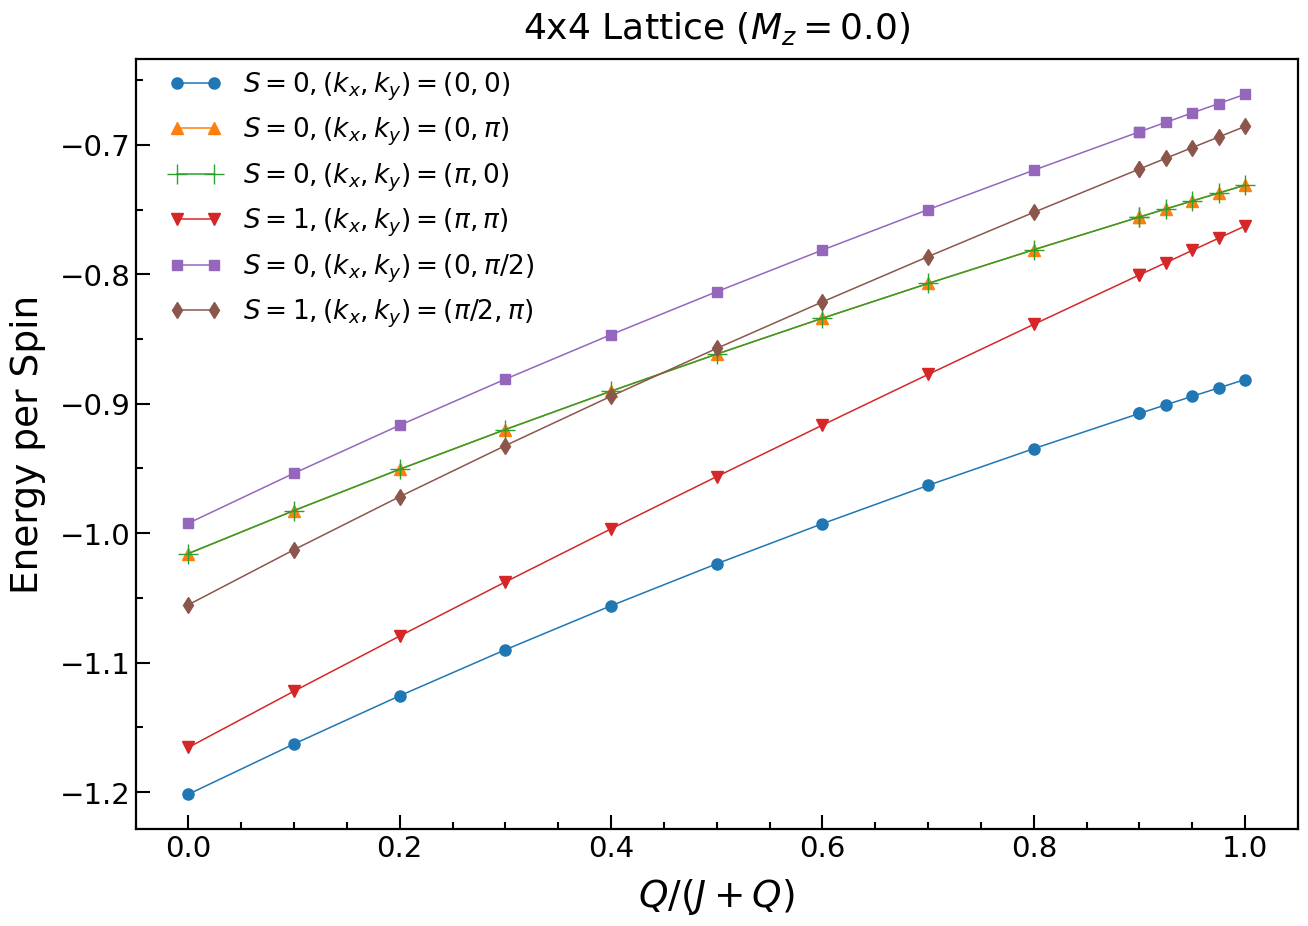

In [3]:
using PyPlot
import PyPlot: matplotlib

# Access the matplotlib.ticker module
ticker = matplotlib["ticker"]

# Set the figure size
figure(figsize=(15,10))

# Set font settings
PyPlot.rc("font", family="sans")  # Set font family
PyPlot.rc("font", serif="Computer Modern")  # Set specific serif font
# PyPlot.rc("font", size=12)  # Set default font size

# Variables a and clip for data ranges
a = 1
clip = length(R_list)

# Plotting the data
plot(R_list[a:clip],energy00[a:clip]./(Nx*Ny),marker=:o,lw=1.1,ms=8,label=L"S=0,(k_x,k_y)=(0,0)")
plot(R_list[a:clip],energy0p_sing[a:clip]./(Nx*Ny),marker=:^,lw=1.1,ms=8,label=L"S=0,(k_x,k_y)=(0,\pi)")
# plot(R_list[a:clip],energy0p_trip[a:clip]./(Nx*Ny),marker=:D,lw=1.1,ms=8,label=L"S=1,(k_x,k_y)=(0,\pi)")
plot(R_list[a:clip],energyp0_sing[a:clip]./(Nx*Ny),marker=:+,lw=1.1,ms=15,label=L"S=0,(k_x,k_y)=(\pi,0)")
# plot(R_list[a:clip],energyp0_trip[a:clip]./(Nx*Ny),marker=:2,lw=1.1,ms=15,label=L"S=1,(k_x,k_y)=(\pi,0)")
plot(R_list[a:clip],energypp[a:clip]./(Nx*Ny),marker=:v,lw=1.1,ms=8,label=L"S=1,(k_x,k_y)=(\pi,\pi)")
plot(R_list[a:clip],energy0p2_sing[a:clip]./(Nx*Ny),marker=:s,lw=1.1,ms=7,label=L"S=0,(k_x,k_y)=(0,\pi/2)")
# plot(R_list[a:clip],energy0p2_trip[a:clip]./(Nx*Ny),marker=:X,lw=1.1,ms=7,label=L"S=1,(k_x,k_y)=(0,\pi/2)")
plot(R_list[a:clip],energyp2p[a:clip][a:clip]./(Nx*Ny),marker=:d,lw=1.1,ms=8,label=L"S=1,(k_x,k_y)=(\pi/2,\pi)")

# Customize the legend position and style
legend(loc=(0.02,0.635), fontsize=19, frameon=false, labelspacing=.5, numpoints=2)
# legend(loc=(0.02,0.75), fontsize=19, frameon=false, labelspacing=.5, numpoints=2)

# xlim(0,1)  # Set X axis limit from 0 to 10
# ylim(-1.25, -0.6)  # Set Y axis limit from -1 to 1

# Customize labels and title
xlabel(L"Q/(J+Q)", fontsize=27,labelpad=10)
ylabel("Energy per Spin", fontsize=27,labelpad=10)
title_text = "$(Nx)x$(Ny) Lattice (\$M_z=$(mz)\$)"
title(title_text,fontsize=26,pad=15)
PyPlot.grid(false)

ax = gca()
ax.spines["top"].set_linewidth(1.6)
ax.spines["right"].set_linewidth(1.6)
ax.spines["bottom"].set_linewidth(1.6)
ax.spines["left"].set_linewidth(1.6)

# Set tick parameters for major ticks
tick_params(axis="both", which="major", labelsize=21, direction="in", length=10, width=1.5)
# Set tick parameters for minor ticks
tick_params(axis="both", which="minor", direction="in", length=5, width=1.5)
# Set major and minor locators
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.9))  # Set major locator for x-axis
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))  # Set minor locator for x-axis
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))  # Set major locator for y-axis
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))  # Set minor locator for y-axis

folder_name = "D:\\Project_Julia\\Plots\\2D_JQ_$(Nx)x$(Ny)"
if !isdir(folder_name)
    mkpath(folder_name)
end
file_path = joinpath(folder_name,"Energies.png")
# PyPlot.savefig(file_path;dpi=300,bbox_inches="tight")
show()